# Model Training 

## Objectives
* Satisfy business rerquirement 2: *"The client is interested in predicting if a cherry tree is healthy or contains powdery mildew."*
    *  Engineer features for modelling
    *  Train a model
    
## Inputs
* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validation
* image shape

## Outputs
* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file

___
### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

### Set Working Directory
Change the working directory from its current folder to its parent folder.

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/oksanaerm/ML/ML-mildew-detection/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [5]:
current_dir = os.getcwd()
current_dir

'/Users/oksanaerm/ML/ML-mildew-detection'

### Set input and output paths
***Inputs***

In [6]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

***Outputs***

In [7]:
version = 'v1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1 already exists. Create a new version


### Set labels

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


### Set Image Shape

In [9]:
# Import saved image shape embedding
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

___
## Confirm Amount of Images to Train, Test and Validate Data
___

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




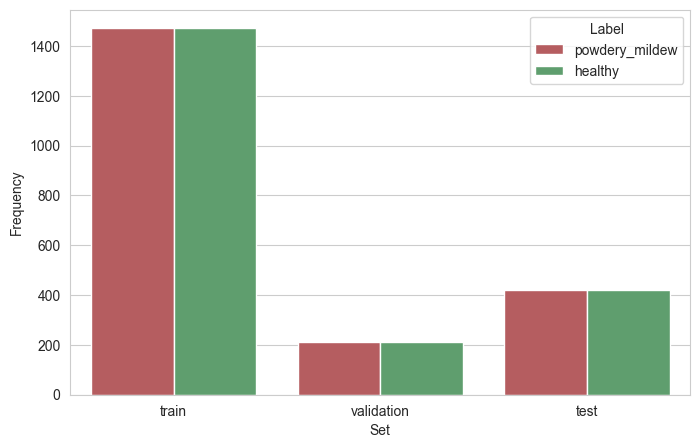

In [15]:
folders = ['train', 'validation', 'test']
# Generate the DataFrame of label frequencies using a list comprehension and os.scandir
df_freq = pd.DataFrame([{'Set': folder,
                         'Label': label,
                         'Frequency': sum(1 for _ in os.scandir(os.path.join(my_data_dir, folder, label)))}
                        for folder in folders
                        for label in labels])
# Print the label frequencies for each folder and label combination
for folder in folders:
    for label in labels:
        print(
            f"* {folder} - {label}: {df_freq[(df_freq['Set'] == folder) & (df_freq['Label'] == label)]['Frequency'].values[0]} images")
# Generate a stacked bar chart of the label frequencies using df_freq.groupby and plot
print("\n")
sns.set_style("whitegrid")
my_colors = ['#C44E52', '#55A868']
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency',
            hue='Label', palette=my_colors)
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


___
## Image Data Augmentation
As we see from the metrics above, the dataset is relatively small compared to some of the large-scale image datasets that are commonly used for training CNNs. That being said, it's not impossible to train a CNN with this dataset, but the model is going to be very prone to overfitting. To mitigate overfitting, you we will use data augmentation techniques to artificially increase the size of the training set.

#### Import DataImageGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-04-04 00:10:52.123612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Initialize DataImageGenerator

In [17]:
augmented_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

#### Loader Parameters

In [18]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

#### Augment Training Dataset Images

In [19]:
train_set = augmented_data.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode=data_color_mode,
                                               batch_size=batch_size,
                                               class_mode=data_class_mode,
                                               shuffle=True
                                               )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment Validation Dataset Images

In [20]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment Test Dataset Images 

In [21]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Plot Augmented Image

In [22]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()

##### Training Image Set

(32, 256, 256, 3)


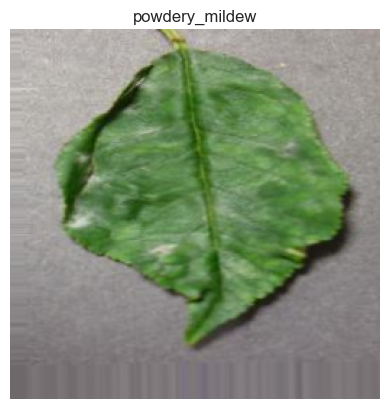

(32, 256, 256, 3)


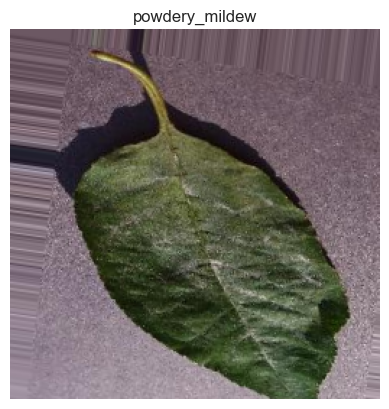

(32, 256, 256, 3)


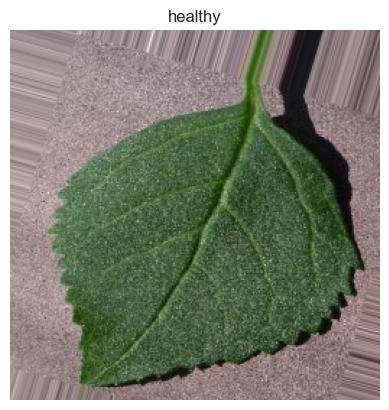

In [25]:
plot_augmented_image(train_set)

##### Validation Image Set

(32, 256, 256, 3)


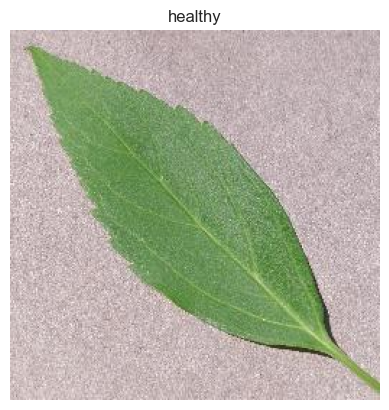

(32, 256, 256, 3)


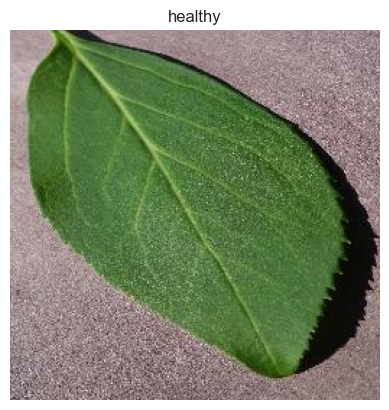

(32, 256, 256, 3)


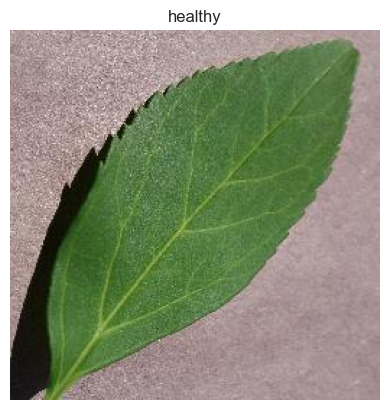

In [24]:
plot_augmented_image(validation_set)

##### Test Image Set

(32, 256, 256, 3)


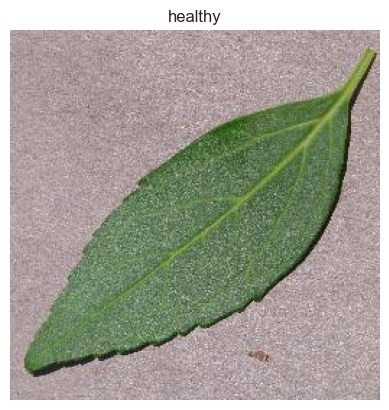

(32, 256, 256, 3)


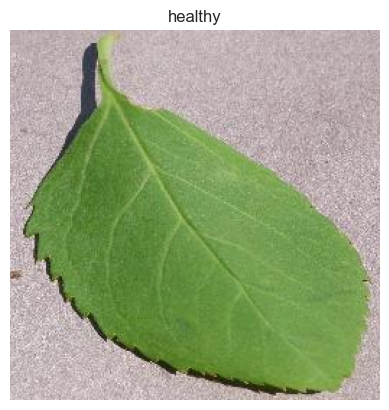

(32, 256, 256, 3)


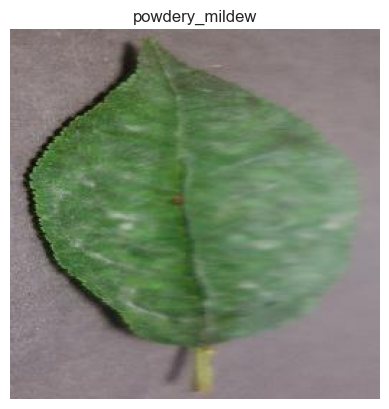

In [30]:
plot_augmented_image(test_set)

Save Class Indices

In [31]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']